<a href="https://colab.research.google.com/github/IjeomaM/dotnet-project/blob/main/IjeomaMaduka23624032_DeepLearning_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Import Packages



In [ ]:
# Import necessary packages.
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# This is for the progress bar
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

# 2 Dataset

## 2.1 Download the Food-11 Dataset

In [ ]:
# Install a package to download data from Kaggle
!pip install -q opendatasets

In [ ]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/trolukovich/food11-image-dataset/')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ijeomamaduka
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/trolukovich/food11-image-dataset


100%|██████████| 1.08G/1.08G [00:09<00:00, 120MB/s]


## 2.2 PyTorch Dataset and Dataloader

In [ ]:
# It is important to do data augmentation in training.
train_transform = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 224)
    transforms.Resize((224, 224)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
# Construct datasets.
train_dataset = datasets.ImageFolder("/content/food11-image-dataset/training", transform=train_transform)
validation_dataset = datasets.ImageFolder("/content/food11-image-dataset/validation", transform=train_transform)
test_dataset = datasets.ImageFolder("/content/food11-image-dataset/evaluation", transform=test_transform)




print(f'Train set has {len(train_dataset)} samples')
print(f'Validation set has {len(validation_dataset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Train set has 9866 samples
Validation set has 3430 samples
Test set has 3347 samples


In [ ]:
# Batch size for training, validation, and testing.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 32

# Construct data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

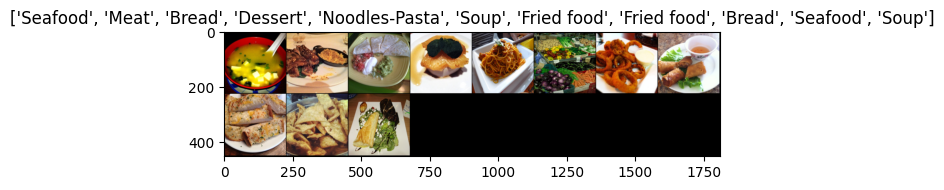

In [ ]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
train_loader_for_vis = DataLoader(train_dataset, batch_size=11, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['Bread', 'Dairy products', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Seafood', 'Soup', 'Vegetable-Fruit']

imshow(out, title=[class_names[x] for x in classes])

# 3 Model -CNN

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 224, 224]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1), # TODO: set a convolution layer with out_channels=256, kernel_size=3, stride=1, padding=1
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0), # TODO: set a max pooling layer with kernel_size=4, stride=4, padding=0
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256*14*14, 256), # TODO: fill in the correct input feature size after flatten. The tensor shape before flatten is (256, 14, 14)
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, 7]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [ ]:
# "cuda" only when GPUs are available and define the device.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
cnnmodel = MyCNN()
cnnmodel = cnnmodel.to(device)

# 4 Define Loss and Optimizer

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(cnnmodel.parameters(), lr=0.0003)

# 5 Train and Validation

In [ ]:


# The number of training epochs.
n_epochs = 20

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    cnnmodel.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = cnnmodel(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    cnnmodel.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = cnnmodel(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(cnnmodel.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 001/020] Train: loss=2.07588, acc=0.25779 | Valid: loss=1.89211, acc=0.34240


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 002/020] Train: loss=1.76947, acc=0.38271 | Valid: loss=1.76619, acc=0.39265


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 003/020] Train: loss=1.57326, acc=0.45878 | Valid: loss=1.58797, acc=0.45245


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 004/020] Train: loss=1.34476, acc=0.53489 | Valid: loss=1.47779, acc=0.49932


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 005/020] Train: loss=1.10215, acc=0.62282 | Valid: loss=1.49666, acc=0.50550


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 006/020] Train: loss=0.82937, acc=0.71919 | Valid: loss=1.62972, acc=0.49643


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 007/020] Train: loss=0.57748, acc=0.80481 | Valid: loss=1.75789, acc=0.50955


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 008/020] Train: loss=0.32941, acc=0.89561 | Valid: loss=2.17411, acc=0.50241


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 009/020] Train: loss=0.18244, acc=0.94337 | Valid: loss=2.60268, acc=0.49354


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 010/020] Train: loss=0.11050, acc=0.96774 | Valid: loss=3.06338, acc=0.47357


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 011/020] Train: loss=0.06323, acc=0.98331 | Valid: loss=3.25528, acc=0.48601


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 012/020] Train: loss=0.08151, acc=0.97417 | Valid: loss=3.03580, acc=0.50212


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 013/020] Train: loss=0.07779, acc=0.97755 | Valid: loss=3.34869, acc=0.51591


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 014/020] Train: loss=0.03544, acc=0.99049 | Valid: loss=3.58212, acc=0.49923


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 015/020] Train: loss=0.05547, acc=0.98463 | Valid: loss=3.35155, acc=0.49412


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 016/020] Train: loss=0.03477, acc=0.98918 | Valid: loss=3.65622, acc=0.48438


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 017/020] Train: loss=0.06116, acc=0.98014 | Valid: loss=3.38723, acc=0.49257


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 018/020] Train: loss=0.02670, acc=0.99242 | Valid: loss=3.95414, acc=0.50029


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 019/020] Train: loss=0.03437, acc=0.98835 | Valid: loss=3.89409, acc=0.48167


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 020/020] Train: loss=0.03287, acc=0.98977 | Valid: loss=4.13181, acc=0.49113


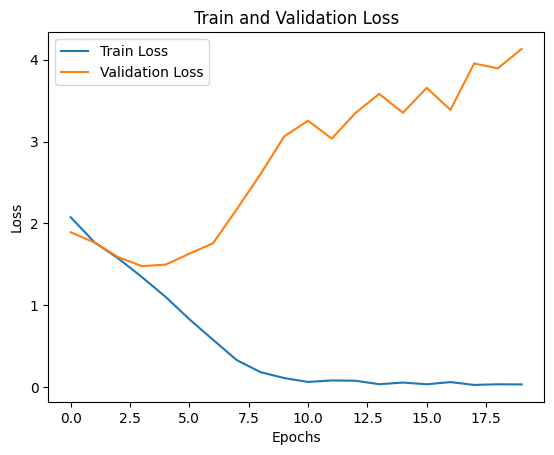

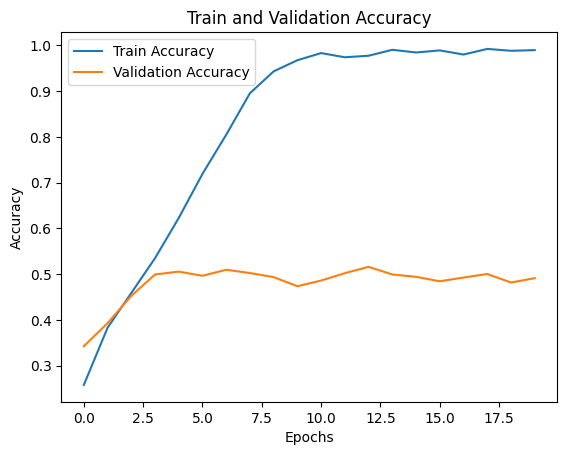

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

From the curve, we can observe the problem of overfitting.

It would be worthy to try regularization techniques, such as dropout. You can also add batchnorm, change the CNN/linear layers (numbers, input/output channels, kernel size, etc.), use well-defined models in torchvision, add data augmentation, etc. You can also try to modify the optimizer. For example, you can reduce the learning rate. There is another way to dynamically change the learning rate during the training - [learning rate scheduling](https://d2l.ai/chapter_optimization/lr-scheduler.html).

In addition, the sample code may not be good enough. You can learn more about PyTorch to enhance it from the coding perspective.

3 Model -RESNET18

In [ ]:

import torchvision.models as models

class MyRESNET(nn.Module):
    def __init__(self):
        super(MyRESNET, self).__init__()
        # Load pre-trained RESNET18 model
        resnet18 = models.resnet18(pretrained=True)

        # Remove the final fully connected layer from RESNET18
        self.features = nn.Sequential(*list(resnet18.children())[:-1])

        # Define additional fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 256),  # Adjust the input size based on the output size of RESNET18
            nn.ReLU(),
            nn.Linear(256, 11)    # Output size 11 for classification
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, 11] for 11 classes

        # Extract features using RESNET18
        x = self.features(x)

        # Flatten the extracted features
        x = torch.flatten(x, 1)

        # Pass through additional fully connected layers
        x = self.fc_layers(x)
        return x




In [ ]:
# Load pretrained ResNet18 model
RESNET_model = models.resnet18(pretrained=True)

# Modify the last fully connected layer to match the number of classes in your dataset
num_ftrs = RESNET_model.fc.in_features
RESNET_model.fc = nn.Linear(num_ftrs, 11)  # Assuming there are 11 classes

# Check if CUDA (GPU) is available and define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create an instance of the MyRESNET model
RESNET_model.to(device)

# Define loss function and optimizer # Initialize optimizer, define loss function using the learning rate of 0.0003.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RESNET_model.parameters(), lr=0.0003)

# Number of training epochs
n_epochs = 20

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    RESNET_model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = RESNET_model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    RESNET_model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = RESNET_model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(RESNET_model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 001/020] Train: loss=0.70641, acc=0.76952 | Valid: loss=0.56705, acc=0.81154


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 002/020] Train: loss=0.32893, acc=0.89045 | Valid: loss=0.64691, acc=0.79688


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 003/020] Train: loss=0.17877, acc=0.94221 | Valid: loss=0.75904, acc=0.77797


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 004/020] Train: loss=0.16010, acc=0.94903 | Valid: loss=0.64844, acc=0.81395


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 005/020] Train: loss=0.09569, acc=0.96855 | Valid: loss=0.83877, acc=0.81096


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 006/020] Train: loss=0.11702, acc=0.96046 | Valid: loss=0.64292, acc=0.83700


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 007/020] Train: loss=0.07937, acc=0.97542 | Valid: loss=0.61757, acc=0.84578


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 008/020] Train: loss=0.08011, acc=0.97559 | Valid: loss=0.72312, acc=0.82166


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 009/020] Train: loss=0.08662, acc=0.97158 | Valid: loss=0.71271, acc=0.82147


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 010/020] Train: loss=0.04853, acc=0.98301 | Valid: loss=0.65412, acc=0.84886


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 011/020] Train: loss=0.05515, acc=0.98402 | Valid: loss=0.71397, acc=0.82485


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 012/020] Train: loss=0.07329, acc=0.97751 | Valid: loss=0.88843, acc=0.79263


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 013/020] Train: loss=0.07782, acc=0.97593 | Valid: loss=0.69668, acc=0.82523


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 014/020] Train: loss=0.05798, acc=0.98125 | Valid: loss=0.69669, acc=0.83131


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 015/020] Train: loss=0.05411, acc=0.98240 | Valid: loss=0.72482, acc=0.83353


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 016/020] Train: loss=0.03526, acc=0.98946 | Valid: loss=0.85399, acc=0.82369


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 017/020] Train: loss=0.07090, acc=0.97591 | Valid: loss=0.68572, acc=0.83787


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 018/020] Train: loss=0.04385, acc=0.98523 | Valid: loss=0.91923, acc=0.81877


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 019/020] Train: loss=0.04256, acc=0.98797 | Valid: loss=0.80557, acc=0.81356


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 020/020] Train: loss=0.02852, acc=0.99039 | Valid: loss=0.77433, acc=0.83102


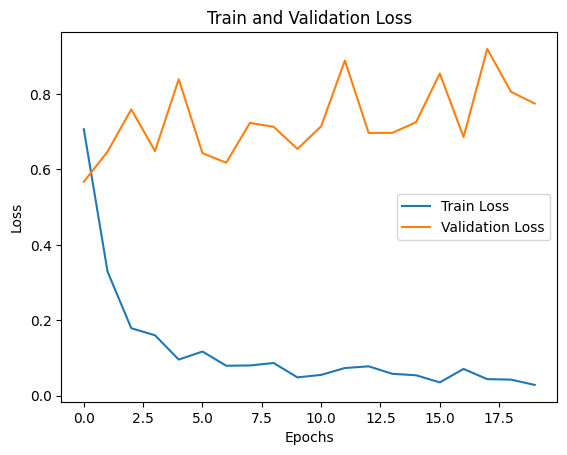

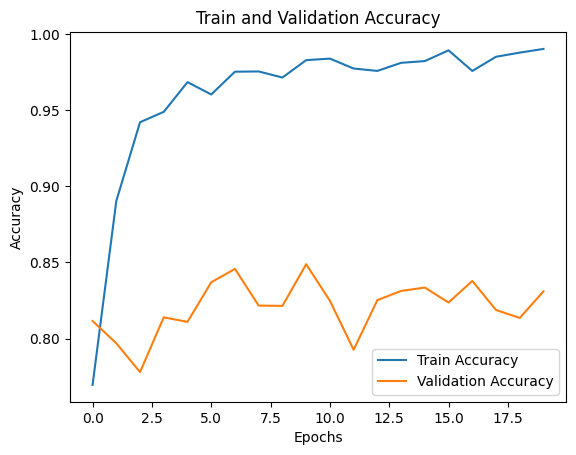

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

Model VGG19


In [ ]:
class MyVGG16(nn.Module):
    def __init__(self):
        super(MyVGG16, self).__init__()
        # The VGG16 architecture consists of convolutional layers followed by fully connected layers.
        # Here, we define the VGG16 layers and initialize them.

        # Convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 64 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # 64 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling with kernel_size=2, stride=2

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 128 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # 128 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling with kernel_size=2, stride=2

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 256 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 256 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 256 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling with kernel_size=2, stride=2

            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 512 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 512 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 512 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling with kernel_size=2, stride=2

            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 512 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 512 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 512 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling with kernel_size=2, stride=2
        )

        # Fully connected layers
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))  # Adaptive average pooling to output size 7x7
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # Fully connected layer with 512*7*7 input features and 4096 output features
            nn.ReLU(inplace=True),
            nn.Dropout(),  # Dropout layer for regularization
            nn.Linear(4096, 4096),  # Fully connected layer with 4096 input features and 4096 output features
            nn.ReLU(inplace=True),
            nn.Dropout(),  # Dropout layer for regularization
            nn.Linear(4096, 11)  # Output layer with 4096 input features and 11 output features (classes)
        )

    def forward(self, x):
        # Forward pass through the network
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten the feature maps
        x = self.classifier(x)
        return x


In [ ]:
# # Check if CUDA (GPU) is available and define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create an instance of the MyVGG16 model
VGG_model = MyVGG16()
# Create an instance of the MyVGG18 model
VGG_model.to(device)


MyVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(VGG_model.parameters(), lr=0.0003)

In [ ]:
# Load pretrained VGG16 model
VGG_model = models.vgg16(pretrained=True)

# Modify the last fully connected layer to match the number of classes in your dataset
num_ftrs = VGG_model.classifier[6].in_features
VGG_model.classifier[6] = nn.Linear(num_ftrs, 11)  # Assuming there are 11 classes

# Check if CUDA (GPU) is available and define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the VGG16 model
VGG_model.to(device)

# Define loss function and optimizer with a learning rate of 0.0003
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(VGG_model.parameters(), lr=0.0003)

# Number of training epochs
n_epochs = 20

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    VGG_model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = VGG_model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    VGG_model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = VGG_model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(VGG_model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 108MB/s]


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 001/020] Train: loss=1.58322, acc=0.45651 | Valid: loss=0.99138, acc=0.66792


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 002/020] Train: loss=0.94320, acc=0.69333 | Valid: loss=0.84252, acc=0.73052


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 003/020] Train: loss=0.70915, acc=0.77259 | Valid: loss=0.86301, acc=0.72415


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 004/020] Train: loss=0.59594, acc=0.81278 | Valid: loss=0.76615, acc=0.76784


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 005/020] Train: loss=0.46014, acc=0.85827 | Valid: loss=0.71182, acc=0.77045


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 006/020] Train: loss=0.36726, acc=0.88418 | Valid: loss=0.76839, acc=0.78492


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 007/020] Train: loss=0.29010, acc=0.90837 | Valid: loss=0.75237, acc=0.79726


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 008/020] Train: loss=0.27491, acc=0.91347 | Valid: loss=0.82494, acc=0.77459


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 009/020] Train: loss=0.22424, acc=0.93062 | Valid: loss=0.83472, acc=0.78347


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 010/020] Train: loss=0.19688, acc=0.93780 | Valid: loss=0.95366, acc=0.74190


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 011/020] Train: loss=0.24924, acc=0.92627 | Valid: loss=0.81254, acc=0.78791


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 012/020] Train: loss=0.12511, acc=0.96268 | Valid: loss=0.98508, acc=0.77836


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 013/020] Train: loss=0.13940, acc=0.95752 | Valid: loss=1.20563, acc=0.76186


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 014/020] Train: loss=0.21619, acc=0.93716 | Valid: loss=0.98499, acc=0.75579


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 015/020] Train: loss=0.14759, acc=0.95540 | Valid: loss=1.05916, acc=0.76688


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 016/020] Train: loss=0.11707, acc=0.96501 | Valid: loss=1.02553, acc=0.78598


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 017/020] Train: loss=0.10907, acc=0.96600 | Valid: loss=0.87322, acc=0.79562


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 018/020] Train: loss=0.13919, acc=0.96106 | Valid: loss=1.10818, acc=0.76881


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 019/020] Train: loss=0.09854, acc=0.96954 | Valid: loss=1.18007, acc=0.77623


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 020/020] Train: loss=0.08820, acc=0.97439 | Valid: loss=1.20600, acc=0.79070


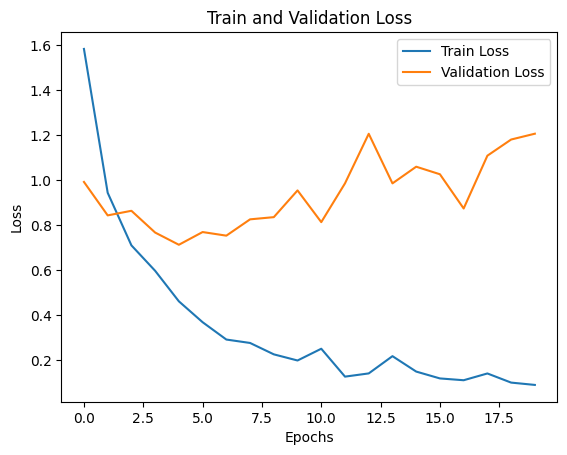

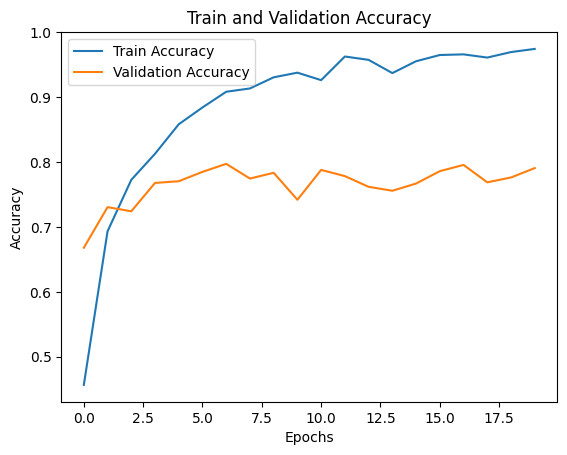

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

Model - DENSENET


In [ ]:
class MyDenseNet(nn.Module):
    def __init__(self):
        super(MyDenseNet, self).__init__()
        # Load pre-trained DenseNet model
        densenet121 = models.densenet121(pretrained=True)

        # Remove the final fully connected layer from DenseNet121
        self.features = nn.Sequential(*list(densenet121.children())[:-1])

        # Define additional fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(1024, 256),  # Adjust the input size based on the output size of DenseNet121
            nn.ReLU(),
            nn.Linear(256, 11)     # Output size 11 for classification
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, 11] for 11 classes

        # Extract features using DenseNet121
        x = self.features(x)

        # Flatten the extracted features
        x = torch.flatten(x, 1)

        # Pass through additional fully connected layers
        x = self.fc_layers(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm

# Load pretrained DenseNet model
DenseNet_model = models.densenet121(pretrained=True)

# Modify the last fully connected layer to match the number of classes in your dataset
num_ftrs = DenseNet_model.classifier.in_features
DenseNet_model.classifier = nn.Linear(num_ftrs, 11)  # Assuming there are 11 classes

# Check if CUDA (GPU) is available and define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the DenseNet model
DenseNet_model.to(device)

# Define loss function and optimizer with a learning rate of 0.0003
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(DenseNet_model.parameters(), lr=0.0003)

# Number of training epochs
n_epochs = 20

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    DenseNet_model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = DenseNet_model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    DenseNet_model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = DenseNet_model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(DenseNet_model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 85.9MB/s]
100%|██████████| 108/108 [00:30<00:00,  3.49it/s]


[Epoch: 001/020] Train: loss=0.63316, acc=0.79790 | Valid: loss=0.53096, acc=0.82398


100%|██████████| 108/108 [00:30<00:00,  3.54it/s]


[Epoch: 002/020] Train: loss=0.29693, acc=0.90443 | Valid: loss=0.50693, acc=0.83873


100%|██████████| 108/108 [00:31<00:00,  3.48it/s]


[Epoch: 003/020] Train: loss=0.19364, acc=0.93746 | Valid: loss=0.44496, acc=0.85484


100%|██████████| 108/108 [00:30<00:00,  3.56it/s]


[Epoch: 004/020] Train: loss=0.15752, acc=0.94630 | Valid: loss=0.53187, acc=0.84954


100%|██████████| 108/108 [00:30<00:00,  3.49it/s]


[Epoch: 005/020] Train: loss=0.12486, acc=0.95928 | Valid: loss=0.45965, acc=0.86545


100%|██████████| 108/108 [00:30<00:00,  3.53it/s]


[Epoch: 006/020] Train: loss=0.11753, acc=0.96266 | Valid: loss=0.42636, acc=0.87751


100%|██████████| 108/108 [00:30<00:00,  3.50it/s]


[Epoch: 007/020] Train: loss=0.07530, acc=0.97743 | Valid: loss=0.56652, acc=0.84375


100%|██████████| 108/108 [00:30<00:00,  3.54it/s]


[Epoch: 008/020] Train: loss=0.09089, acc=0.96962 | Valid: loss=0.43398, acc=0.87413


100%|██████████| 108/108 [00:30<00:00,  3.53it/s]


[Epoch: 009/020] Train: loss=0.08469, acc=0.97229 | Valid: loss=0.58130, acc=0.84327


100%|██████████| 108/108 [00:30<00:00,  3.57it/s]


[Epoch: 010/020] Train: loss=0.06372, acc=0.97856 | Valid: loss=0.56147, acc=0.84867


100%|██████████| 108/108 [00:30<00:00,  3.49it/s]


[Epoch: 011/020] Train: loss=0.05810, acc=0.98139 | Valid: loss=0.50551, acc=0.86545


100%|██████████| 108/108 [00:30<00:00,  3.58it/s]


[Epoch: 012/020] Train: loss=0.06253, acc=0.97917 | Valid: loss=1.05404, acc=0.77257


100%|██████████| 108/108 [00:30<00:00,  3.50it/s]


[Epoch: 013/020] Train: loss=0.07238, acc=0.97563 | Valid: loss=0.63818, acc=0.84144


100%|██████████| 108/108 [00:30<00:00,  3.59it/s]


[Epoch: 014/020] Train: loss=0.05773, acc=0.98188 | Valid: loss=0.46653, acc=0.88011


100%|██████████| 108/108 [00:30<00:00,  3.52it/s]


[Epoch: 015/020] Train: loss=0.05406, acc=0.98271 | Valid: loss=0.51336, acc=0.86892


100%|██████████| 108/108 [00:30<00:00,  3.59it/s]


[Epoch: 016/020] Train: loss=0.04203, acc=0.98574 | Valid: loss=0.53534, acc=0.85928


100%|██████████| 108/108 [00:30<00:00,  3.53it/s]


[Epoch: 017/020] Train: loss=0.05430, acc=0.98097 | Valid: loss=0.58478, acc=0.86053


100%|██████████| 108/108 [00:30<00:00,  3.55it/s]


[Epoch: 018/020] Train: loss=0.06053, acc=0.98008 | Valid: loss=0.49621, acc=0.88387


100%|██████████| 108/108 [00:31<00:00,  3.48it/s]


[Epoch: 019/020] Train: loss=0.04024, acc=0.98685 | Valid: loss=0.51991, acc=0.87375


100%|██████████| 108/108 [00:30<00:00,  3.58it/s]

[Epoch: 020/020] Train: loss=0.04308, acc=0.98513 | Valid: loss=0.53939, acc=0.85918


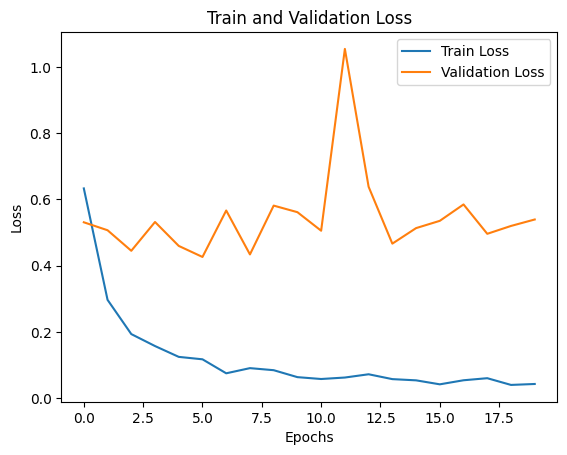

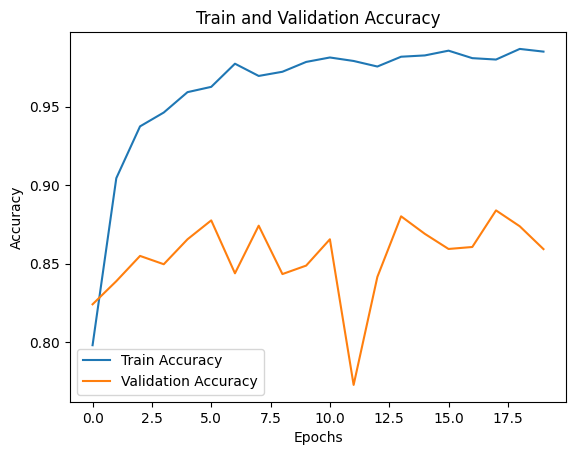

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Load best model weights
DenseNet_model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
DenseNet_model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = DenseNet_model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')


100%|██████████| 105/105 [00:22<00:00,  4.60it/s]

Test accuracy 0.9053571820259094


# 7 Improve Performance

## 7.1 Data Augmentation

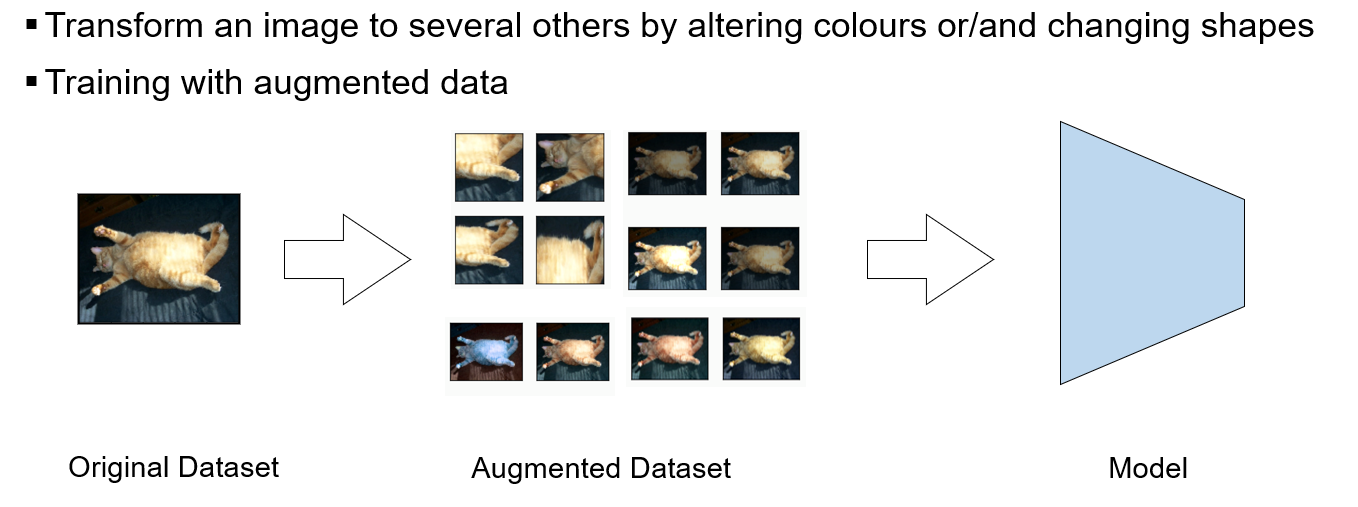

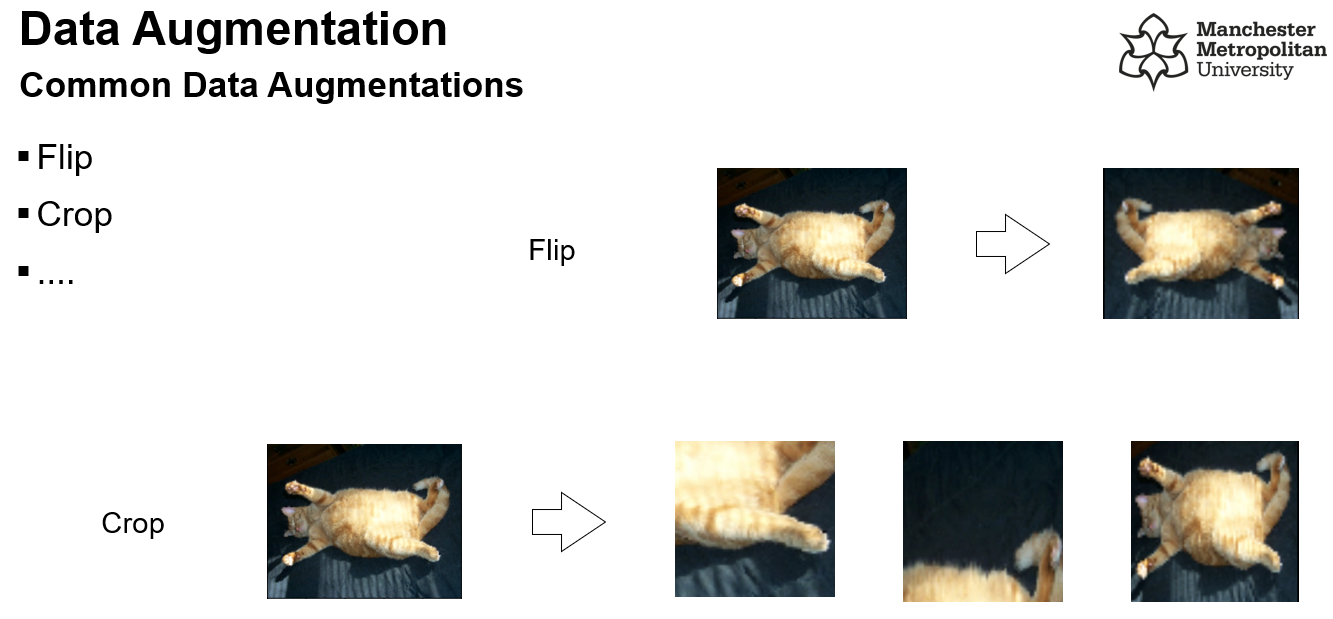